<a href="https://colab.research.google.com/github/krithikaceg/functional_intro_to_python/blob/master/waste_management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np # MATRIX OPERATIONS
import pandas as pd # EFFICIENT DATA STRUCTURES
import matplotlib.pyplot as plt # GRAPHING AND VISUALIZATIONS
import math # MATHEMATICAL OPERATIONS
import cv2 # IMAGE PROCESSING - OPENCV
from glob import glob # FILE OPERATIONS
import itertools

# KERAS AND SKLEARN MODULES
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


# GLOBAL VARIABLES
scale = 70
seed = 7

In [0]:
zip_images = 'dataset-resized.zip'
import zipfile
zip_ref = zipfile.ZipFile(zip_images, 'r')
zip_ref.extractall("wm-dataset")
zip_ref.close()


In [20]:

path_to_images = 'wm-dataset/dataset-resized/*/*.jpg'
images = glob(path_to_images)
trainingset = []
traininglabels = []
num = len(images)
count = 1
#READING IMAGES AND RESIZING THEM
for i in images:
    print(str(count)+'/'+str(num),end='\r')
    trainingset.append(cv2.resize(cv2.imread(i),(scale,scale)))
    traininglabels.append(i.split('/')[-2])
    count=count+1
trainingset = np.asarray(trainingset)
print(set(traininglabels))
traininglabels = pd.DataFrame(traininglabels)

{'cardboard', 'trash', 'glass', 'metal', 'plastic', 'paper'}


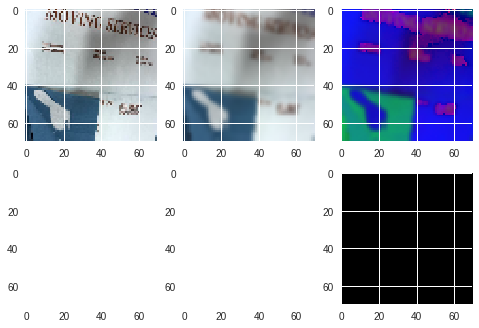

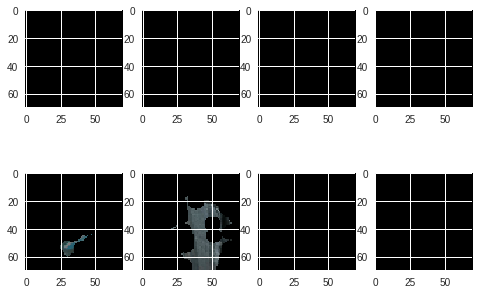

In [21]:
new_train = []
sets = []; getEx = True
for i in trainingset:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    #GREEN PARAMETERS
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    new_train.append(new)
    
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i) # ORIGINAL
        plt.subplot(2,3,2);plt.imshow(blurr) # BLURRED
        plt.subplot(2,3,3);plt.imshow(hsv) # HSV CONVERTED
        plt.subplot(2,3,4);plt.imshow(mask) # MASKED
        plt.subplot(2,3,5);plt.imshow(boolean) # BOOLEAN MASKED
        plt.subplot(2,3,6);plt.imshow(new) # NEW PROCESSED IMAGE
        plt.show()
        getEx = False
new_train = np.asarray(new_train)

# CLEANED IMAGES
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(new_train[i])

Classes['cardboard' 'glass' 'metal' 'paper' 'plastic' 'trash']
6


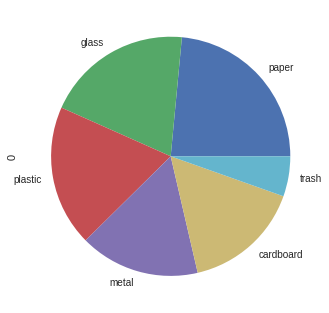

In [22]:
labels = preprocessing.LabelEncoder()
labels.fit(traininglabels[0])
print('Classes'+str(labels.classes_))
encodedlabels = labels.transform(traininglabels[0])
clearalllabels = np_utils.to_categorical(encodedlabels)
classes = clearalllabels.shape[1]
print(str(classes))
traininglabels[0].value_counts().plot(kind='pie')

In [0]:
new_train = new_train/255
x_train,x_test,y_train,y_test = train_test_split(new_train,clearalllabels,test_size=0.1,random_state=seed,stratify=clearalllabels)

In [0]:
generator = ImageDataGenerator(rotation_range = 180,zoom_range = 0.1,width_shift_range = 0.1,height_shift_range = 0.1,horizontal_flip = True,vertical_flip = True)
generator.fit(x_train)

In [31]:
np.random.seed(seed)

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(scale, scale, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 66, 66, 64)        4864      
_________________________________________________________________
batch_normalization_27 (Batc (None, 66, 66, 64)        256       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 62, 62, 64)        102464    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 31, 31, 64)        256       
_________________________________________________________________
dropout_15 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 27, 27, 128)       204928    
__________

In [26]:
print(model.evaluate(x_train, y_train))  # Evaluate on train set
print(model.evaluate(x_test, y_test))  # Evaluate on test set

2274/2274 [==============================] - 90s 39ms/step
[1.7909876215111926, 0.23306948109058928]
253/253 [==============================] - 10s 40ms/step
[1.7913725324299024, 0.2094861667146796]


In [27]:
y_pred = model.predict(x_test)
y_class = np.argmax(y_pred, axis = 1) 
y_check = np.argmax(y_test, axis = 1) 

cmatrix = confusion_matrix(y_check, y_class)
print(cmatrix)

[[33  4  3  0  0  0]
 [19 10 19  2  0  0]
 [24 10  7  0  0  0]
 [27 16 13  3  0  1]
 [27  7 13  1  0  0]
 [10  1  2  1  0  0]]
